In [1]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# importing the 'Value' type
from utils import Value, MLP
from utils import PalindromeDataset, PalindromeDatasetFull

## Example : To show that the backprop implementation works

In [3]:
# Example computation
a = Value(1)
b = Value(2)
c = Value(3)
d = Value(4)

e = a*b + c*d
f = e/2.

# checking final values and initial grads (should be zero)
print(e, f, a.grad, b.grad, c.grad, d.grad, e.grad, f.grad)

# backprop
f.backward()

# checking final grads
print(e, f, a.grad, b.grad, c.grad, d.grad, e.grad, f.grad)

Value(data=14) Value(data=7.0) 0 0 0 0 0 0
Value(data=14) Value(data=7.0) 1.0 0.5 2.0 1.5 0.5 1


## Testing the implementation of NN using dummy model and data

In [4]:
# showing the training of a simple NN, with some data
# input dim=3, output dim=1, atchitecture : NN with 4 layers : 3,4,4,1 neurons resp
from utils import MLP

# testing the MLP 
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1]
]
ys = [1,-1,-1,1] # labels
losslog = []
a = MLP(3, [4,4,1])
for step in range(200) : # 200 epochs
    # forward pass
    ypred = [a(x)[0] for x in xs]
    loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad # standard SGD for now

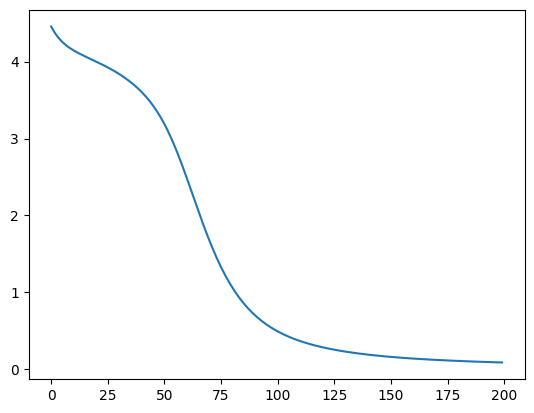

In [5]:
plt.plot(losslog)
plt.show()

In [6]:
# checking performance on the four data points
# should be close to ys=[1,-1,-1,1]
[a(x)[0] for x in xs]

[Value(data=0.8442281397216626),
 Value(data=-0.8781425781240726),
 Value(data=-0.8376995370875562),
 Value(data=0.8563240746183143)]

## Final Model Training

In [3]:
datasetMaker = PalindromeDataset(10)
dataset = datasetMaker.generate_dataset(512, 512) # note that the dataset is balanced

In [4]:
len(dataset)

1024

In [5]:
def convert_to_form(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs.append([int(k) for k in list(x)])
        ys.append(y)
    return xs, ys

In [6]:
# showing the training of a simple NN, with some data
# input dim=10, output dim=1, architecture : NN with 1 hidden layers : 4 with neurons
from utils import MLP
from tqdm.auto import tqdm

losslog = []
a = MLP(10, [4, 1])
weight = 1. # added weight to try and counter the class imbalance
nepochs = 751

xs, ys = convert_to_form(dataset)

for step in tqdm(range(nepochs)) : 
    # forward pass
    ypred = [a(x)[0] for x in xs]
    # loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    loss = sum(-weight*ytrue*ypred.log()-(1-ytrue)*(1-ypred).log() for ytrue, ypred in zip(ys, ypred)) # BCE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()

    if step%50==0 : tqdm.write(f'epoch {step} loss {loss.data:.4f}')
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad # standard SGD for now

  0%|          | 0/751 [00:00<?, ?it/s]

epoch 0 loss 711.3794
epoch 50 loss 672.6159
epoch 100 loss 505.5235
epoch 150 loss 353.9375
epoch 200 loss 128.7723
epoch 250 loss 72.7497
epoch 300 loss 50.2509
epoch 350 loss 36.2794
epoch 400 loss 27.1792
epoch 450 loss 20.9476
epoch 500 loss 16.7682
epoch 550 loss 13.8930
epoch 600 loss 11.8366
epoch 650 loss 10.3048
epoch 700 loss 9.1220
epoch 750 loss 8.1813


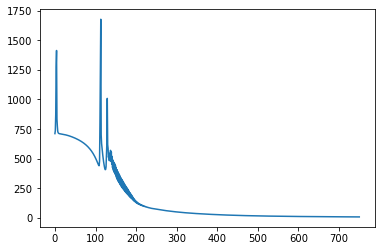

In [7]:
plt.plot(losslog)
plt.show()

In [8]:
eps = 1e-8
predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    thresh = i/10
    preds = np.array(1*(predictions > thresh))

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    # true_pos = sum(np.array(ys)==1 and preds==1)
    # true_neg = sum(np.array(ys)==0 and preds==0)
    # false_pos = sum(np.array(ys)==0 and preds==1)
    # false_neg = sum(np.array(ys)==1 and preds==0)

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)
    print(f'Threshold {thresh:.1f} accuracy {acc:.4f} f1 {f1:.4f}')

Threshold 0.1 accuracy 0.9961 f1 0.9961
Threshold 0.2 accuracy 1.0000 f1 1.0000
Threshold 0.3 accuracy 1.0000 f1 1.0000
Threshold 0.4 accuracy 1.0000 f1 1.0000
Threshold 0.5 accuracy 1.0000 f1 1.0000
Threshold 0.6 accuracy 1.0000 f1 1.0000
Threshold 0.7 accuracy 1.0000 f1 1.0000
Threshold 0.8 accuracy 1.0000 f1 1.0000
Threshold 0.9 accuracy 1.0000 f1 1.0000


In [9]:
max(predictions), min(predictions)

(0.99405742881954, 5.738456171342238e-11)

In [10]:
from sklearn.metrics import confusion_matrix

# testing on full dataset
test_datasetMaker = PalindromeDatasetFull(10)
test_dataset = test_datasetMaker.generate_dataset()

xs, ys = convert_to_form(test_dataset)

predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    preds = 1*(predictions > i/10)

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)

    print(i/10, acc, f1)

confusion_matrix(ys, preds)

0.1 0.970703125 0.6808510591942055
0.2 0.986328125 0.8205128154635108
0.3 0.9912109375 0.8767123236029274
0.4 0.9931640625 0.901408445498909
0.5 0.994140625 0.9142857090612244
0.6 0.994140625 0.9142857090612244
0.7 0.994140625 0.9142857090612244
0.8 0.994140625 0.9142857090612244
0.9 1.0 0.9999999946875


array([[992,   0],
       [  0,  32]], dtype=int64)

In [12]:
preds = 1*(predictions > 0.9)

true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

num_correct = true_neg + true_pos
prec = true_pos / (true_pos + false_pos + eps)
recall = true_pos / (true_pos + false_neg + eps)
f1 = 2*prec*recall / (prec + recall + eps)
acc = num_correct / len(ys)

print(i/10, acc, f1)

confusion_matrix(ys, preds)

0.9 1.0 0.9999999946875


array([[992,   0],
       [  0,  32]], dtype=int64)

In [40]:
# loading the weights
import pickle

path = './model_wts.pkl'
weights = [x.data for x in a.parameters()]

with open(path, 'wb') as F :
    pickle.dump(weights, F)

In [41]:
# loading the weights
with open(path, 'rb') as F :
    test = pickle.load(F)

In [57]:
# function to evaluate the model given weight array
def evaluate(weights, inp) :
    # weights is a 49-len list
    # input is a 10-len binary values list
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    weights = np.array(weights)
    inp = np.array(inp)

    one = sum(weights[:10]*inp) + weights[10]
    two = sum(weights[11:21]*inp) + weights[21]
    three = sum(weights[22:32]*inp) + weights[32]
    four = sum(weights[33:43]*inp) + weights[43]
    vals = np.array([one, two, three, four])
    vals = sigmoid(vals)
    
    return sigmoid(sum(weights[44:48]*vals) + weights[48])